# **Advection Equation**

This notebook solves the **advection equation** $u_t + a u_x=0$ using as an initial condition a **gaussian profile** $u(x,t=0)=\exp{[-(x-x_0)^2]}$ with $x_0=5$ or a **_step function_** $u(x,t=0)=1$ _if_ $x\in [4,6]$.

We use a domain $x\in [0,10]$ with _periodic boundary conditions_.

Both the initial conditions and the scheme to be used can be chosen by modifying few parameters where indicated.

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import os
import imageio

# **Parameters of the problem**

In [27]:
# Define the speed a
a = 1.0

# Define the domain
L = 10.0 # Domain length
hundreds = 1 # Hundreds of points to be used
nx = 1 + hundreds * 100 # Number of grid points

dx = L / (nx - 1) # Grid spacing
x_grid = np.linspace(0, L, nx)

# Define the time step and the final time
cf = 0.5 # Courant factor
dt = cf * dx / a # Time step
t_final = 20.0

print("nx =", nx)
print("dx =", dx)
print("dt =", dt)
print("Number of iterations =", t_final / dt)

nx = 101
dx = 0.1
dt = 0.05
Number of iterations = 400.0


# **Method selection**

Down below one can choose the method to be used to solve the advection equation by changing the index to subscript the "methods" list. See comments.

In [28]:
# Wether to save the results or not
save_results = False

In [29]:
#             0       1        2          3
methods = ["FTCS", "LAX-F", "LAX-W", "LEAPFROG"]

# ***
# METHOD TO BE USED
#------------------------------------------------
method = methods[2]
#------------------------------------------------
# ***

# **Initial condition selection**

Same as for the method selection

In [30]:
#                       0       1
intial_conditions = ["GAUS", "STEP"]

# ***
# INITIAL CONDITION
#------------------------------------------------
initial_condition = intial_conditions[1]
#------------------------------------------------
# ***

# Files managing + **Initial condition generation**

Mainly definition of variables for saving files and making plots.

The generation of the initial condition is highlighted by comments.

In [31]:
# File paths variables
if method.lower() == "ftcs":
    method_dir_path = "FTCS"
    l2_norm_data_path = "l2norm_FTCS.dat"
elif method.lower() == "lax-f":
    method_dir_path = "LAX-FRIEDRICHS"
    l2_norm_data_path = "l2norm_LAX.dat"
elif method.lower() == "leapfrog":
    method_dir_path = "LEAPFROG"
    l2_norm_data_path = "l2norm_LEAPFROG.dat"
elif method.lower() == "lax-w":
    method_dir_path = "LAX-WENDROFF"
    l2_norm_data_path = "l2norm_LAXWENDROFF.dat"

# Support strings for file names and plot labels
par_str = "Cf-" + str(cf) + "_N-" + str(nx)
par_label = r'$C_f=$' + str(cf) + r'$;\ N=$' + str(nx)

# String for file names
movie_name = par_str + ".mp4"
l2_img_name = "l2_" + par_str + ".png" # l2 norm
IF_img_name = "IF_" + par_str + ".png" # Intial/Final
l2_data_name = "l2_" + par_str + ".npz"
IF_data_name = "IF_" + par_str + ".npz"

if initial_condition.lower() == "gaus":
    folder_name = "GAUS"
    # ***
    # INITIAL CONDITION
    #------------------------------------------------
    x0 = 5
    u_initial = np.exp(-(x_grid - x0) ** 2)
    #------------------------------------------------
    # ***
elif initial_condition.lower() == "step":
    folder_name = "STEP"
    # ***
    # INITIAL CONDITION
    #------------------------------------------------
    u_initial = np.zeros(nx)
    x_inf, x_sup = 4, 6
    u_initial[(x_grid >= 4) & (x_grid <= 6)] = 1
    #------------------------------------------------
    # ***

# Path of folders to be used to save results
folder_path = os.path.join(method_dir_path, folder_name)
movie_dir_path = os.path.join(folder_path, "movies")
frames_dir_path = os.path.join(movie_dir_path, "frames")
images_dir_path = os.path.join(folder_path, "images")
data_dir_path = os.path.join(folder_path, "data")

movie_frame_name_prefix = "img_"

# Files managing

Creating and clearing folders.

Some folders are untouched because we store the results in it.

In [32]:
if save_results:
    # Create the folders if they don't exists
    os.makedirs(frames_dir_path, exist_ok=True) # Makes also the movie path
    os.makedirs(images_dir_path, exist_ok=True)
    os.makedirs(data_dir_path, exist_ok=True)

    # Empty the 'frames' folder
    for file_name in os.listdir(frames_dir_path):
        file_path = os.path.join(frames_dir_path, file_name)
        os.remove(file_path)

    # Empty the 'intial function' folder
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        if os.path.isfile(file_path):
            os.remove(file_path)

    # Empty the 'method' folder
    for file_name in os.listdir(method_dir_path):
        file_path = os.path.join(method_dir_path, file_name)
        if os.path.isfile(file_path):
            os.remove(file_path)
    
    # Don't touch the images, movies and data folders where different results are stored

# **Initialisation**

Initialisation of the variables to solve the advection equation.

In [33]:
# Initialise the solution array
u_current = u_initial.copy()

# We create arrays where we will store the time and the l2norm
l2norm = []
l2norm.append(np.sqrt(np.sum(u_current ** 2) / len(u_current))) # l2norm at the initial time

time = []
time.append(0.0) # Append the initial time

# **Evolution of the initial condition** and frames saving

The choosen scheme is used to solve the advection equation with the specified initial condition.

Some snapshots of the solution are saved if required, otherwise only the intial and final snapshots are shown after this.

In [34]:
# Initialize time and iteration counter
t = 0.0
i = 0

# Save the initial conditions
if save_results:
    plt.plot(x_grid, u_current)
    plt.title(r'$Time=$' + str(round(t, 2)) + '; ' + par_label)
    plt.ylim(0, 1.1)

    frame_name = movie_frame_name_prefix + str(i).zfill(5) + ".png"
    frame_path = os.path.join(frames_dir_path, frame_name)
    plt.savefig(frame_path, dpi=200)
    plt.close()

# Solve the advection equation
while t < t_final:
    # Compute the new solution using the FTCS method
    # Note: np.roll(u_current, -1) is equivalent to u(j+1) and
    #       np.roll(u_current,  1) is equivalent to u(j-1)
    # Using np.roll is equivalent to use periodic boundary conditions

    if method.lower() == "ftcs":
        factor = a * dt / (2 * dx)
        u_next = u_current - factor * (np.roll(u_current, -1) - np.roll(u_current, 1))
    elif method.lower() == "lax-f":
        factor = a * dt / (2 * dx)
        u_next = (1 / 2) * (np.roll(u_current, -1) + np.roll(u_current, 1)) - factor * (np.roll(u_current, -1) - np.roll(u_current, 1))    
    elif method.lower() == "lax-w":
        factor = a * dt / dx
        u_next = u_current - (1 / 2) * factor * (np.roll(u_current, -1) - np.roll(u_current, 1)) + (1 / 2) * (factor ** 2) * (np.roll(u_current, -1) - 2 * u_current + np.roll(u_current, 1))
    elif method.lower() == "leapfrog":
        if i == 0: # Use LAX-F
            factor = a * dt / (2 * dx)
            u_next = (1 / 2) * (np.roll(u_current, -1) + np.roll(u_current, 1)) - factor * (np.roll(u_current, -1) - np.roll(u_current, 1))
            u_previous = u_initial.copy()
        else:
            factor = a * dt / dx
            u_next = u_previous - factor * (np.roll(u_current, -1) - np.roll(u_current, 1))
            u_previous = u_current.copy()

    # Update the solution
    u_current = u_next.copy()

    # Advance the time 
    t += dt
    i += 1
    
    # Compute the l2 norm and add the time to the time vector
    l2norm.append(np.sqrt(np.sum(u_current ** 2) / len(u_current)))
    time.append(t)
    
    # Save some snapshots
    if save_results:
        # Plot the current result and save in an image every 10 iterations
        if (i % (10 * hundreds) == 0):
            plt.plot(x_grid, u_current)
            plt.title(r'$Time=$' + str(round(t, 2)) + '; ' + par_label)
            plt.ylim(0, 1.1)
            frame_name = movie_frame_name_prefix + str(i).zfill(5) + ".png"
            frame_path = os.path.join(frames_dir_path, frame_name)
            plt.savefig(frame_path, dpi=200)
            plt.close()


# **Initial and final snapshots**

Plots of the intial and final snaoshots.

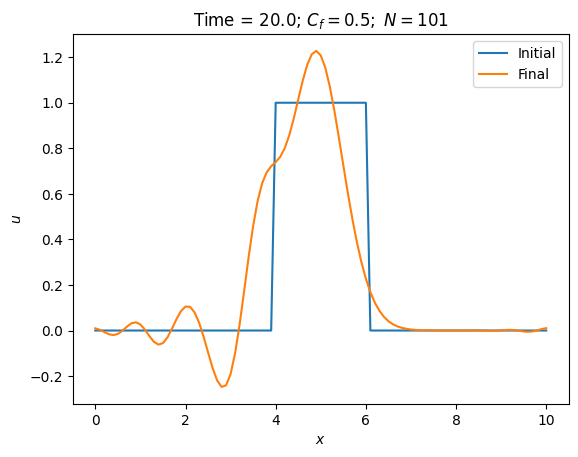

In [35]:
# Plot the initial and final solution
plt.plot(x_grid, u_initial, label='Initial')
plt.plot(x_grid, u_current, label='Final')

plt.title('Time = ' + str(round(t, 2)) + '; ' + par_label)
plt.xlabel(r'$x$')
plt.ylabel(r'$u$')
# plt.ylim(0,1.1)

plt.legend()

# Save the results
if save_results:
    plt.savefig(os.path.join(images_dir_path, IF_img_name), dpi=200)
    np.savez(os.path.join(data_dir_path, IF_data_name),
             x_grid=x_grid,
             u_i=u_initial,
             u_f=u_current,
             par_label=par_label)

plt.show()

# Movie maker

Make a movie of the solutions using the saved snaposhots.

In [36]:
if save_results:
    # Get the list of image files in the directory
    files = os.listdir(frames_dir_path)

    # Sort the files in alphanumeric order
    files = sorted(files)

    movie_path = os.path.join(movie_dir_path, movie_name)

    with imageio.get_writer(movie_path, mode='I', quality=10) as writer:
        for file in files:
            image = imageio.imread(os.path.join(frames_dir_path, file))
            writer.append_data(image)
            
    files = []

# Files managing

Delete frames if required (delete_frames = True).

In [37]:
if save_results:
    # Empty the 'frames' folder
    delete_frames = True

    if delete_frames:
        for file_name in os.listdir(frames_dir_path):
            file_path = os.path.join(frames_dir_path, file_name)
            os.remove(file_path)

# **$L_2$ Norm**

Plot the $L_2$ norm normalized at its initial value.

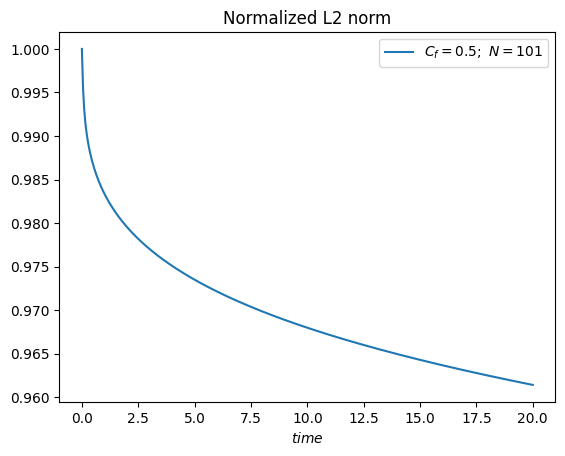

In [38]:
# Normalize the l2norm at its initial value
l2norm_normalized = np.array(l2norm) / l2norm[0]

# Compare l2norm with data stored
plt.title("Normalized L2 norm")
plt.plot(time, l2norm_normalized, label=par_label)
plt.xlabel(r'$time$')

# Overplot the saved data (just for the gaussian profile)
if initial_condition == "GAUS":
    l2_saved = np.genfromtxt(l2_norm_data_path, comments='#')
    # Normalize also the saved l2norm
    l2_saved_normalized = l2_saved[:, 1] / l2_saved[1][1]
    plt.plot(l2_saved[:, 0], l2_saved_normalized, '+', label=r'$C_f=0.5;\ N=101$')

plt.legend()

# Save the plot
if save_results:
    plt.savefig(os.path.join(images_dir_path, l2_img_name), dpi=200)
    np.savez(os.path.join(data_dir_path, l2_data_name),
             time=time,
             l2norm=l2norm_normalized,
             par_label=par_label)

plt.show()